In [62]:
import argparse
import torch
import wandb
import numpy as np
from dassl.utils import setup_logger, set_random_seed, collect_env_info
from dassl.config import get_cfg_default
from dassl.engine import build_trainer

In [2]:
def print_args(args, cfg):
    print('***************')
    print('** Arguments **')
    print('***************')
    optkeys = list(args.__dict__.keys())
    optkeys.sort()
    for key in optkeys:
        print('{}: {}'.format(key, args.__dict__[key]))
    print('************')
    print('** Config **')
    print('************')
    print(cfg)

In [3]:
def setup_cfg(args):
    cfg = get_cfg_default()
    reset_cfg(cfg, args)
    if args.dataset_config_file:
        cfg.merge_from_file(args.dataset_config_file)
    if args.config_file:
        cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    return cfg

In [4]:
def reset_cfg(cfg, args):
    if args.root:
        cfg.DATASET.ROOT = args.root

    if args.output_dir:
        cfg.OUTPUT_DIR = args.output_dir

    if args.resume:
        cfg.RESUME = args.resume

    if args.seed:
        cfg.SEED = args.seed

    if args.source_domains:
        cfg.DATASET.SOURCE_DOMAINS = args.source_domains

    if args.target_domains:
        cfg.DATASET.TARGET_DOMAINS = args.target_domains

    if args.transforms:
        cfg.INPUT.TRANSFORMS = args.transforms

    if args.trainer:
        cfg.TRAINER.NAME = args.trainer

    if args.backbone:
        cfg.MODEL.BACKBONE.NAME = args.backbone

    if args.head:
        cfg.MODEL.HEAD.NAME = args.head

    #if args.uncertainty:
    cfg.MODEL.UNCERTAINTY = args.uncertainty

    #if args.pos:
    cfg.MODEL.POS = args.pos

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument('--root', type=str, default='./DATA', help='path to dataset')
parser.add_argument(
    '--output-dir', type=str, default='../output/dg/pacs/conststyle/art_painting', help='output directory'
)
parser.add_argument(
    '--resume',
    type=str,
    default='',
    help='checkpoint directory (from which the training resumes)'
)
parser.add_argument(
    '--seed',
    type=int,
    default=1,
    help='only positive value enables a fixed seed'
)
parser.add_argument(
    '--source-domains',
    type=str,
    nargs='+',
    default='cartoon photo sketch'.split(),
    help='source domains for DA/DG'
)
parser.add_argument(
    '--target-domains',
    type=str,
    nargs='+',
    default=['art_painting'],
    help='target domains for DA/DG'
)
parser.add_argument(
    '--transforms', type=str, nargs='+', help='data augmentation methods'
)
parser.add_argument(
    '--config-file', type=str, default='../configs/trainers/dg/vanilla/pacs.yaml', help='path to config file'
)
parser.add_argument(
    '--dataset-config-file',
    type=str,
    default='../configs/datasets/dg/pacs_cs.yaml',
    help='path to config file for dataset setup'
)
parser.add_argument(
    '--trainer', type=str, default='ConstStyleTrainer', help='name of trainer'
)
parser.add_argument(
    '--backbone', type=str, default='', help='name of CNN backbone'
)
parser.add_argument('--head', type=str, default='', help='name of head')
parser.add_argument(
    '--eval-only', action='store_true', help='evaluation only'
)
parser.add_argument(
    '--model-dir',
    type=str,
    default='',
    help='load model from this directory for eval-only mode'
)
parser.add_argument(
    '--load-epoch',
    type=int,
    help='load model weights at this epoch for evaluation'
)
parser.add_argument(
    '--no-train', action='store_true', help='do not call trainer.train()'
)
parser.add_argument(
    'opts',
    default=None,
    nargs=argparse.REMAINDER,
    help='modify config options using the command-line'
)
parser.add_argument('--uncertainty', default=0.0, type=float)
parser.add_argument('--pos', nargs='+', type=int, default=[],
                    help='pos for uncertainty')
parser.add_argument('--wandb', default=0, type=int, help='visualize on Wandb')
parser.add_argument('--option', default='', type=str, help='additional options')
parser.add_argument('--update_interval', default=20, type=int, help='update cluster interval')

args = parser.parse_args('')

In [6]:
cfg = setup_cfg(args)
if args.wandb:
    if 'u' in cfg.MODEL.BACKBONE.NAME:
        job_type = 'DSU'
    elif 'c' in cfg.MODEL.BACKBONE.NAME:
        job_type = 'ConstStyle'
    else:
        job_type = 'Baseline'
    
    if cfg.MODEL.BACKBONE.PRETRAINED:
        job_type += '-pretrained'
        
    tracker = wandb.init(
        project = 'StyleDG',
        entity = 'aiotlab',
        config = args,
        group = f'{cfg.DATASET.NAME}',
        name = f'train={cfg.DATASET.SOURCE_DOMAINS}_test={cfg.DATASET.TARGET_DOMAINS}_type={args.option}',
        job_type = job_type
    )
    args.tracker = tracker

if cfg.SEED >= 0:
    print('Setting fixed seed: {}'.format(cfg.SEED))
    set_random_seed(cfg.SEED)
setup_logger(cfg.OUTPUT_DIR)

if torch.cuda.is_available() and cfg.USE_CUDA:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

print_args(args, cfg)

trainer = build_trainer(cfg, args)

Setting fixed seed: 1
***************
** Arguments **
***************
backbone: 
config_file: ../configs/trainers/dg/vanilla/pacs.yaml
dataset_config_file: ../configs/datasets/dg/pacs_cs.yaml
eval_only: False
head: 
load_epoch: None
model_dir: 
no_train: False
option: 
opts: []
output_dir: ../output/dg/pacs/conststyle/art_painting
pos: []
resume: 
root: ./DATA
seed: 1
source_domains: ['cartoon', 'photo', 'sketch']
target_domains: ['art_painting']
trainer: ConstStyleTrainer
transforms: None
uncertainty: 0.0
update_interval: 20
wandb: 0
************
** Config **
************
DATALOADER:
  K_TRANSFORMS: 1
  NUM_WORKERS: 8
  TEST:
    BATCH_SIZE: 128
    SAMPLER: SequentialSampler
  TRAIN_U:
    BATCH_SIZE: 32
    N_DOMAIN: 0
    SAME_AS_X: True
    SAMPLER: RandomSampler
  TRAIN_X:
    BATCH_SIZE: 64
    N_DOMAIN: 0
    SAMPLER: RandomSampler
DATASET:
  ALL_AS_UNLABELED: False
  CIFAR_C_LEVEL: 1
  CIFAR_C_TYPE: 
  NAME: PACS
  NUM_LABELED: 250
  ROOT: ./DATA
  SOURCE_DOMAINS: ['cartoon', 

In [7]:
trainer.load_model(cfg.OUTPUT_DIR, epoch=50)

Loading weights to model from "../output/dg/pacs/conststyle/art_painting/model/model.pth.tar-50" (epoch = 50)
Total batch: 7
Epoch 1
Output: tensor([[ 3.4461e+00, -5.1808e+00, -5.3964e+00, -1.5486e+00,  5.1280e+00,
          4.0709e+00,  1.3106e+00],
        [ 3.0012e+00, -5.4633e-01, -5.0635e+00, -3.3795e+00,  4.0394e+00,
         -4.8063e-02,  3.2434e+00],
        [ 1.7176e+00,  1.3926e+00, -2.7185e+00,  3.2065e-01,  2.2533e+00,
          4.4221e-01, -1.2102e+00],
        [ 8.6074e+00, -4.5821e+00,  2.8449e-01, -2.5706e+00,  3.1907e+00,
         -1.6708e+00, -2.0737e+00],
        [ 6.8343e+00, -4.5703e+00, -4.7775e-01, -2.7966e-01,  5.5177e+00,
         -1.8810e+00, -2.2410e+00],
        [ 4.4012e+00, -2.3685e+00, -4.5903e+00, -1.4717e+00, -2.1255e-01,
          3.9763e+00, -2.3845e-01],
        [ 1.1792e+01, -5.1347e+00, -2.9203e+00, -1.0752e+00,  3.4906e+00,
         -8.5979e-01, -2.0539e+00],
        [ 1.0297e+01,  4.6896e-01, -2.0430e+00, -4.4898e+00,  3.2329e+00,
         -4.104

In [56]:
val_loader = trainer.val_loader
print(f'Total batch: {len(val_loader)}')
for idx, batch in enumerate(val_loader):
    images, label = trainer.parse_batch_test(batch)
    output = trainer.model(images, store_feature=True)

In [55]:
for idx, conststyle in enumerate(trainer.model.backbone.conststyle):
    conststyle.clear_memory()

In [57]:
id_mean = []
id_std = []
total_id_samples = 0
for idx, conststyle in enumerate(trainer.model.backbone.conststyle):
    if idx == 0:
        print(f'Len {len(conststyle.mean)}')
        id_mean.extend(conststyle.mean)
        id_std.extend(conststyle.std)
        total_id_samples += len(conststyle.mean)

In [58]:
test_loader = trainer.test_loader
print(f'Total batch: {len(test_loader)}')
for idx, batch in enumerate(test_loader):
    input, label = trainer.parse_batch_test(batch)
    output = trainer.model(input, store_feature=True)

In [59]:
od_mean = []
od_std = []
total_od_samples = 0
for idx, conststyle in enumerate(trainer.model.backbone.conststyle):
    if idx == 0:
        od_mean.extend(conststyle.mean)
        od_std.extend(conststyle.std)
        total_od_samples += len(conststyle.mean)

In [63]:
id_mean = np.array(id_mean)
od_mean = np.array(od_mean)
id_std = np.array(id_std)
od_std = np.array(od_std)

In [71]:
total_mean = np.vstack((id_mean, od_mean))
total_std = np.vstack((id_std, od_std))

In [83]:
total_data = np.hstack((total_mean, total_std))

In [93]:
id_label = [1 for i in range(total_id_samples)]
od_label = [2 for i in range(total_od_samples)]

In [94]:
total_label = np.hstack((id_label, od_label))
total_label

array([1, 1, 1, ..., 2, 2, 2])

In [79]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE 

In [85]:
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(total_data)

In [89]:
transformed_data.shape

(3660, 2)

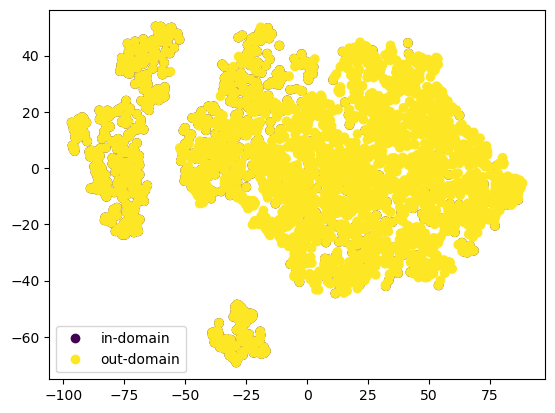

In [95]:
classes = ['in-domain', 'out-domain']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=total_label)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()